Number of datasets: 200
Number of columns: 11
Columns: TITLE, AUTHOR, PUBLISHED, ISBN, PAGE_NUM, URL, TOPICS, COPYRIGHT, DESCRIPTION, DATE, LANGUAGE
Processing blurbs...


100%|██████████| 200/200 [00:03<00:00, 59.63it/s]


                        TITLE           AUTHOR      PUBLISHED           ISBN  \
0             Family Activism   Roberto Vargas  Jun 08, 2008   9781576754801   
1            Woof at the Door   Laura Morrigan  Jul 02, 2013   9780425257197   
2                Snowy Sunday     Phyllis Root  Sep 29, 2015   9780763636272   
3  Once Upon a Midnight Eerie  Gordon McAlpine  Jan 22, 2015   9780142423493   
4              It All Adds Up      Saul Bellow  Jun 05, 2018   9780143106685   

     PAGE_NUM                                                URL  \
0   272 Pages  https://www.penguinrandomhouse.com/books/57484...   
1   304 Pages  https://www.penguinrandomhouse.com/books/31107...   
2    24 Pages  https://www.penguinrandomhouse.com/books/25840...   
3   208 Pages  https://www.penguinrandomhouse.com/books/31167...   
4   384 Pages  https://www.penguinrandomhouse.com/books/31023...   

                                              TOPICS  \
0                               Nonfiction, Politics  

C:\Users\Oliver\AppData\Local\Temp\ipykernel_10080\3865949939.py:78: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarity_score = nlp(text1).similarity(nlp(text2))


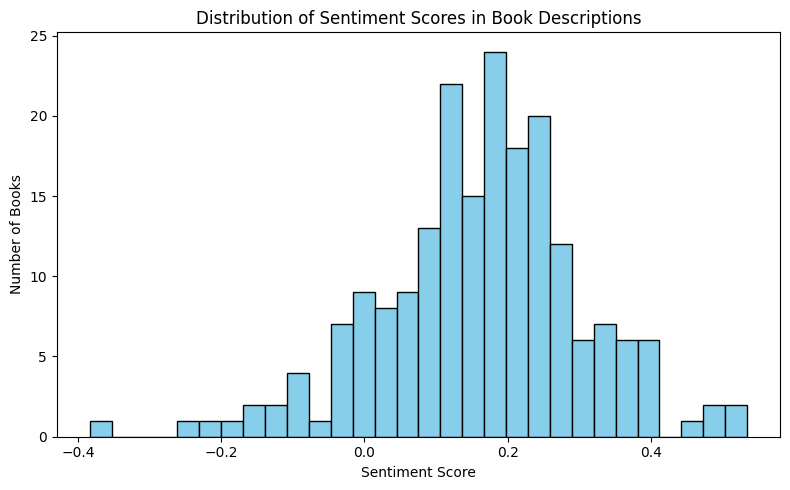

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import spacy
from textblob import TextBlob
from tqdm import tqdm
from utilities import read_xml

# === Load spaCy English model ===
nlp = spacy.load("en_core_web_sm")

# === Load Dataset ===
PATH_DEV = os.path.join(os.getcwd(), 'origdata', 'BlurbGenreCollection_EN_dev.txt')
PATH_TEST = os.path.join(os.getcwd(), 'origdata', 'BlurbGenreCollection_EN_test.txt')
PATH_TRAIN = os.path.join(os.getcwd(), 'origdata', 'BlurbGenreCollection_EN_train.txt')

df_train = read_xml(PATH_TRAIN)
df_test = read_xml(PATH_TEST)
df_dev = read_xml(PATH_DEV)

# Combine into a single DataFrame
df = pd.concat([df_train, df_test, df_dev])

# === OPTIONAL: Reduce dataset for faster testing ===
df = df.sample(200, random_state=42).copy()

# === Basic Info ===
print('Number of datasets:', df.shape[0])
print('Number of columns:', df.shape[1])
print('Columns:', ', '.join(df.columns))

# === spaCy NLP Helper Functions ===
def extract_entities(doc):
    return [(ent.text, ent.label_) for ent in doc.ents]

def preprocess_doc(doc):
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

def extract_keyphrases(doc):
    return [chunk.text for chunk in doc.noun_chunks]

def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

# === Prepare NLP columns ===
df['NER_Entities'] = None
df['Processed_Text'] = None
df['Key_Phrases'] = None
df['Sentiment_Score'] = None

df.reset_index(drop=True, inplace=True)

# === Process Descriptions with spaCy ===
descriptions = df['DESCRIPTION'].fillna("").tolist()
print("Processing blurbs...")

processed_docs = list(tqdm(nlp.pipe(descriptions), total=len(descriptions)))

# Fill new columns using processed spaCy docs
for i, doc in enumerate(processed_docs):
    df.at[i, 'NER_Entities'] = extract_entities(doc)
    df.at[i, 'Processed_Text'] = preprocess_doc(doc)
    df.at[i, 'Key_Phrases'] = extract_keyphrases(doc)
    df.at[i, 'Sentiment_Score'] = analyze_sentiment(doc.text)

# === Display DataFrame (Notebook) or head() for script use ===
try:
    import ace_tools as tools
    tools.display_dataframe_to_user(name="Processed Book Data", dataframe=df)
except:
    print(df.head())

# === Example: Text Similarity Between Two Books ===
text1 = df.iloc[0]['DESCRIPTION']
text2 = df.iloc[1]['DESCRIPTION']´´
similarity_score = nlp(text1).similarity(nlp(text2))
print(f"\nSimilarity between Book 1 and Book 2: {similarity_score:.2f}")

# === Plot Sentiment Score Distribution ===
plt.figure(figsize=(8,5))
plt.hist(df['Sentiment_Score'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Books')
plt.title('Distribution of Sentiment Scores in Book Descriptions')
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from collections import Counter

df_classify = df[['DESCRIPTION', 'TOPICS']].dropna().copy()
df_classify['TOPIC_LIST'] = df_classify['TOPICS'].apply(lambda x: [t.strip() for t in x.split(',')])

all_topics = [genre for sublist in df_classify['TOPIC_LIST'] for genre in sublist]
topic_counts = Counter(all_topics)
MIN_OCCURRENCES = 10
df_classify['TOPIC_LIST'] = df_classify['TOPIC_LIST'].apply(lambda genres: [g for g in genres if topic_counts[g] >= MIN_OCCURRENCES])
df_classify = df_classify[df_classify['TOPIC_LIST'].map(len) > 0]

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df_classify['DESCRIPTION'])

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_classify['TOPIC_LIST'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0))


                               precision    recall  f1-score   support

            Biography  Memoir       0.00      0.00      0.00         0
             Children’s Books       0.00      0.00      0.00        10
Children’s Middle Grade Books       0.00      0.00      0.00         5
                      Fiction       1.00      0.24      0.38        17
        Graphic Novels  Manga       0.00      0.00      0.00         0
           Historical Fiction       0.00      0.00      0.00         5
                      History       0.00      0.00      0.00         2
             Literary Fiction       0.00      0.00      0.00         4
            Mystery  Suspense       0.00      0.00      0.00         6
                   Nonfiction       0.00      0.00      0.00        12
         Religion  Philosophy       0.00      0.00      0.00         3
                      Romance       0.00      0.00      0.00         5
           Suspense  Thriller       0.00      0.00      0.00         3
     

                               precision    recall  f1-score   support

            Biography  Memoir       0.00      0.00      0.00         0
             Children’s Books       0.00      0.00      0.00        10
Children’s Middle Grade Books       0.00      0.00      0.00         5
                      Fiction       1.00      0.24      0.38        17
        Graphic Novels  Manga       0.00      0.00      0.00         0
           Historical Fiction       0.00      0.00      0.00         5
                      History       0.00      0.00      0.00         2
             Literary Fiction       0.00      0.00      0.00         4
            Mystery  Suspense       0.00      0.00      0.00         6
                   Nonfiction       0.00      0.00      0.00        12
         Religion  Philosophy       0.00      0.00      0.00         3
                      Romance       0.00      0.00      0.00         5
           Suspense  Thriller       0.00      0.00      0.00         3
     

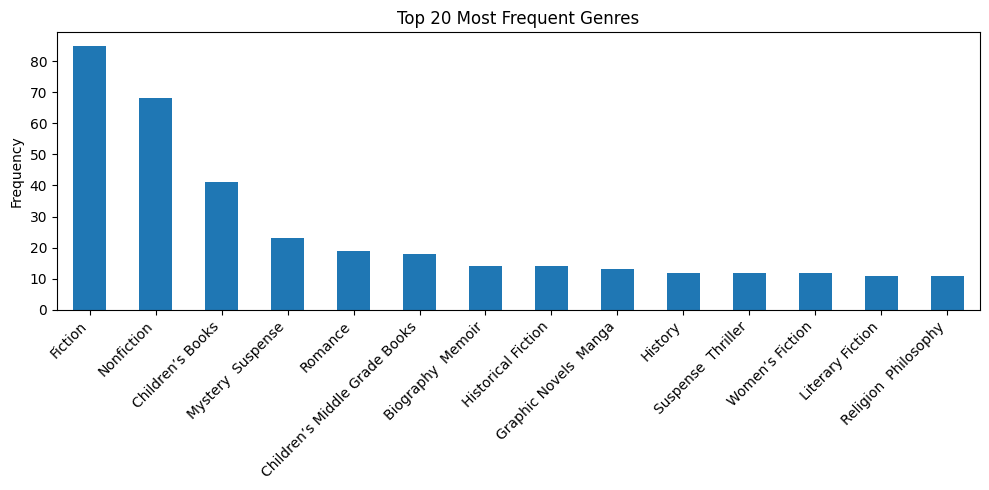

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt
import joblib

df_classify = df[['DESCRIPTION', 'TOPICS']].dropna().copy()
df_classify['TOPIC_LIST'] = df_classify['TOPICS'].apply(lambda x: [t.strip() for t in x.split(',')])

all_topics = [genre for sublist in df_classify['TOPIC_LIST'] for genre in sublist]
topic_counts = Counter(all_topics)
MIN_OCCURRENCES = 10
df_classify['TOPIC_LIST'] = df_classify['TOPIC_LIST'].apply(lambda genres: [g for g in genres if topic_counts[g] >= MIN_OCCURRENCES])
df_classify = df_classify[df_classify['TOPIC_LIST'].map(len) > 0]

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df_classify['DESCRIPTION'])

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_classify['TOPIC_LIST'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0))

joblib.dump(clf, 'genre_classifier.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(mlb, 'label_binarizer.pkl')

top_genres = pd.Series([g for sublist in df_classify['TOPIC_LIST'] for g in sublist]).value_counts().head(20)
plt.figure(figsize=(10, 5))
top_genres.plot(kind='bar')
plt.title('Top 20 Most Frequent Genres')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
